# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                 
Sample_141  Q99972                                            14.967
Sample_101  A2A2V1;P04156;P04156-2                            22.246
Sample_097  P36871;P36871-2                                   15.057
Sample_114  A0A087X0M8                                        16.800
Sample_000  F8W9L4;I6LM06;P22607;P22607-2;P22607-3;P22607-4   17.118
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_199  Q15293            14.951
Sample_047  P15531;P15531-2   13.804
Sample_003  O95479;R4GMU1     16.861
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.720
            A0A075B6Q5                 12.483
            A0A075B6R2                 11.696
            A0A075B6S5                 13.533
            A0A087WSY4                 14.613
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.049
            Q9UI40;Q9UI40-2            12.497
            Q9UIW2                     13.152
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.047
            Q9UP79                     13.031
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.218,15.050,16.842,19.863,16.028,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.651,19.067,...,15.528,15.576,14.129,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.876,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.239,17.705,17.039,16.475,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.358,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.332,15.345,17.084,18.708,14.249,19.433,10.838,10.772
Sample_207,15.739,16.877,15.469,16.898,14.917,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.752,12.162,13.551,10.973,12.198,12.992,11.997,12.515,11.608,12.739
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.754,19.067,16.127,...,12.230,12.343,13.721,12.599,12.710,12.570,13.625,12.877,10.964,12.305
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.205,12.924,13.063,13.034,12.708,12.022,12.888,14.688,12.486,13.283
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.867,12.721,13.165,14.650,13.325,13.128,12.391,13.128,14.050,12.936
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.133,12.912,13.055,11.816,12.128,13.367,11.465,12.801,11.862,13.813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.305,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 307.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.20it/s]

100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.07it/s]

100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.87it/s]

100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.82it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.36it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.21it/s]

100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.50it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.95it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.09it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

100%|██████████| 6/6 [00:01<00:00,  4.16it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.07it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.22it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.23it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.81it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.35it/s]

100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.00it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.93it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.22it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.88it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.70it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.62it/s]

100%|██████████| 8/8 [00:02<00:00,  3.57it/s]

100%|██████████| 8/8 [00:02<00:00,  3.91it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.86it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.32it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.02it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.17it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.23it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.22it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.45it/s]

100%|██████████| 9/9 [00:02<00:00,  4.17it/s]

100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.78it/s]

 30%|███       | 3/10 [00:00<00:01,  6.09it/s]

 40%|████      | 4/10 [00:00<00:01,  5.13it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.09it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.83it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.83it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.64it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.58it/s]

100%|██████████| 10/10 [00:01<00:00,  4.92it/s]

100%|██████████| 10/10 [00:01<00:00,  5.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.49it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.25it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.34it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.87it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.90it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.93it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.49it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.49it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.49it/s]

100%|██████████| 11/11 [00:02<00:00,  4.55it/s]

100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.61it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.27it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.67it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.53it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.53it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.57it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.81it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.78it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.77it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.75it/s]

100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.47it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.23it/s]

 31%|███       | 4/13 [00:00<00:02,  3.79it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.51it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.40it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.48it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.56it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.48it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.56it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.56it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.69it/s]

100%|██████████| 13/13 [00:03<00:00,  3.74it/s]

100%|██████████| 13/13 [00:03<00:00,  3.71it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.78it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.70it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.93it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.99it/s]

 43%|████▎     | 6/14 [00:01<00:01,  5.04it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.55it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.87it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.57it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.39it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.56it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.63it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.90it/s]

100%|██████████| 14/14 [00:03<00:00,  4.06it/s]

100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.19it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.28it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.84it/s]

 40%|████      | 6/15 [00:00<00:01,  7.60it/s]

 47%|████▋     | 7/15 [00:00<00:01,  7.51it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.89it/s]

 60%|██████    | 9/15 [00:01<00:00,  7.07it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.09it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.52it/s]

 80%|████████  | 12/15 [00:01<00:00,  4.55it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.17it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  4.08it/s]

100%|██████████| 15/15 [00:02<00:00,  4.32it/s]

100%|██████████| 15/15 [00:02<00:00,  5.64it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.047 0.018          0.766 0.340       0.113   
2             0.004 0.003      0.042 0.015          0.647 0.097       0.559   
3             0.004 0.002      0.047 0.018          0.692 0.112       0.655   
4             0.004 0.002      0.037 0.004          0.695 0.102       0.649   
5             0.004 0.002      0.037 0.006          0.759 0.103       0.716   
6             0.003 0.001      0.034 0.004          0.784 0.091       0.793   
7             0.004 0.003      0.036 0.005          0.783 0.089       0.791   
8             0.003 0.001      0.032 0.008          0.819 0.096       0.786   
9             0.003 0.000      0.038 0.005          0.833 0.091       0.818   
10            0.003 0.001      0.028 0.007          0.828 0.093       0.823   
11            0.003 0.000      0.035 0.010          0.825 0.088       0.819   
12            0.005 0.005      0.041 0.014          0.822 0.090       0.818   
13            0.003 0.002      0.030 0.009          0.813 0.088       0.822   
14            0.003 0.001      0.033 0.010          0.819 0.088       0.818   
15            0.003 0.001      0.032 0.008          0.813 0.090       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.190 0.123                  0.549 0.039        0.851   
2          0.123   0.594 0.099                  0.668 0.069        0.754   
3          0.141   0.666 0.108                  0.719 0.084        0.799   
4          0.139   0.664 0.103                  0.719 0.079        0.802   
5          0.108   0.731 0.082                  0.772 0.069        0.832   
6          0.124   0.783 0.083                  0.815 0.070        0.896   
7          0.120   0.781 0.082                  0.814 0.069        0.893   
8          0.113   0.796 0.077                  0.827 0.063        0.898   
9          0.105   0.822 0.079                  0.848 0.068        0.915   
10         0.104   0.821 0.079                  0.847 0.068        0.916   
11         0.103   0.818 0.076                  0.845 0.065        0.914   
12         0.103   0.816 0.077                  0.843 0.066        0.913   
13         0.104   0.813 0.075                  0.840 0.065        0.912   
14         0.092   0.815 0.069                  0.841 0.059        0.916   
15         0.093   0.808 0.071                  0.835 0.062        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.088        210.000 0.000  
2          0.070                  0.720 0.082        210.000 0.000  
3          0.073                  0.761 0.096        210.000 0.000  
4          0.075                  0.760 0.099        210.000 0.000  
5          0.071                  0.806 0.084        210.000 0.000  
6          0.054                  0.875 0.061        210.000 0.000  
7          0.055                  0.872 0.063        210.000 0.000  
8          0.052                  0.868 0.068        210.000 0.000  
9          0.051                  0.898 0.059        210.000 0.000  
10         0.052                  0.900 0.060        210.000 0.000  
11         0.053                  0.898 0.061        210.000 0.000  
12         0.053                  0.897 0.061        210.000 0.000  
13         0.053                  0.896 0.060        210.000 0.000  
14         0.052                  0.902 0.057        210.000 0.000  
15         0.052                  0.901 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 824.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 12.71it/s]

100%|██████████| 2/2 [00:00<00:00, 12.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.87it/s]

100%|██████████| 3/3 [00:00<00:00,  6.81it/s]

100%|██████████| 3/3 [00:00<00:00,  6.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.02it/s]

100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.90it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.65it/s]

 80%|████████  | 4/5 [00:00<00:00,  6.48it/s]

100%|██████████| 5/5 [00:00<00:00,  6.40it/s]

100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 12.52it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.87it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.36it/s]

100%|██████████| 6/6 [00:00<00:00,  7.02it/s]

100%|██████████| 6/6 [00:00<00:00,  7.54it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.57it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.36it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  7.10it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.56it/s]

100%|██████████| 7/7 [00:01<00:00,  6.49it/s]

100%|██████████| 7/7 [00:01<00:00,  6.97it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.41it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.02it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.97it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  5.66it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.58it/s]

100%|██████████| 8/8 [00:01<00:00,  5.77it/s]

100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 12.75it/s]

 44%|████▍     | 4/9 [00:00<00:00,  8.03it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  7.49it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  7.08it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  6.84it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.68it/s]

100%|██████████| 9/9 [00:01<00:00,  6.60it/s]

100%|██████████| 9/9 [00:01<00:00,  7.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.80it/s]

 40%|████      | 4/10 [00:00<00:00,  6.14it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.83it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.63it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.66it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.83it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.00it/s]

100%|██████████| 10/10 [00:01<00:00,  6.12it/s]

100%|██████████| 10/10 [00:01<00:00,  6.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.74it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.71it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.25it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.89it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.62it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.57it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.62it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.63it/s]

100%|██████████| 11/11 [00:01<00:00,  6.72it/s]

100%|██████████| 11/11 [00:01<00:00,  6.98it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.29it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.92it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.55it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.24it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.29it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.67it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.83it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.98it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.12it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.58it/s]

100%|██████████| 12/12 [00:02<00:00,  3.88it/s]

100%|██████████| 12/12 [00:02<00:00,  4.74it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.27it/s]

 31%|███       | 4/13 [00:00<00:01,  7.98it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.45it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.20it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  6.84it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.66it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.73it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.62it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.51it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  6.75it/s]

100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.48it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.59it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.63it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.11it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.01it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.71it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.65it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.61it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.57it/s]

100%|██████████| 14/14 [00:01<00:00,  8.55it/s]

100%|██████████| 14/14 [00:01<00:00,  9.11it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.63it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.48it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.29it/s]

 40%|████      | 6/15 [00:00<00:01,  6.77it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.63it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.71it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.67it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.71it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.16it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.55it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.84it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.04it/s]

100%|██████████| 15/15 [00:02<00:00,  8.05it/s]

100%|██████████| 15/15 [00:02<00:00,  7.47it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.006          0.010 0.071       0.001   
2             0.002 0.000      0.021 0.005          0.164 0.334       0.022   
3             0.002 0.000      0.019 0.000          0.788 0.103       0.733   
4             0.002 0.000      0.022 0.005          0.784 0.089       0.744   
5             0.002 0.000      0.021 0.005          0.789 0.101       0.737   
6             0.002 0.001      0.022 0.007          0.792 0.095       0.774   
7             0.002 0.001      0.022 0.005          0.790 0.091       0.776   
8             0.002 0.000      0.020 0.004          0.797 0.093       0.773   
9             0.002 0.001      0.023 0.005          0.834 0.080       0.783   
10            0.002 0.001      0.022 0.005          0.833 0.081       0.783   
11            0.004 0.004      0.037 0.015          0.834 0.080       0.786   
12            0.003 0.001      0.031 0.011          0.836 0.079       0.787   
13            0.002 0.000      0.020 0.001          0.848 0.085       0.814   
14            0.002 0.000      0.020 0.002          0.843 0.086       0.833   
15            0.002 0.000      0.019 0.000          0.852 0.084       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.857   
2          0.053   0.036 0.079                  0.504 0.018        0.802   
3          0.092   0.756 0.085                  0.793 0.071        0.876   
4          0.094   0.761 0.079                  0.796 0.066        0.877   
5          0.087   0.759 0.081                  0.795 0.067        0.886   
6          0.105   0.779 0.085                  0.812 0.071        0.890   
7          0.106   0.779 0.083                  0.812 0.069        0.889   
8          0.106   0.780 0.080                  0.813 0.067        0.888   
9          0.105   0.802 0.070                  0.833 0.057        0.920   
10         0.103   0.802 0.069                  0.833 0.057        0.917   
11         0.099   0.805 0.068                  0.834 0.056        0.916   
12         0.109   0.806 0.074                  0.836 0.061        0.922   
13         0.115   0.825 0.080                  0.852 0.065        0.923   
14         0.103   0.833 0.072                  0.858 0.062        0.925   
15         0.104   0.833 0.075                  0.858 0.064        0.929   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.086        210.000 0.000  
2          0.109                  0.764 0.125        210.000 0.000  
3          0.056                  0.854 0.067        210.000 0.000  
4          0.054                  0.853 0.067        210.000 0.000  
5          0.056                  0.866 0.067        210.000 0.000  
6          0.054                  0.865 0.069        210.000 0.000  
7          0.056                  0.863 0.072        210.000 0.000  
8          0.055                  0.862 0.071        210.000 0.000  
9          0.045                  0.891 0.063        210.000 0.000  
10         0.046                  0.888 0.064        210.000 0.000  
11         0.046                  0.887 0.063        210.000 0.000  
12         0.045                  0.894 0.062        210.000 0.000  
13         0.044                  0.898 0.058        210.000 0.000  
14         0.043                  0.901 0.057        210.000 0.000  
15         0.042                  0.908 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1613.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 52.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.26it/s]

100%|██████████| 5/5 [00:00<00:00, 44.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.04it/s]

100%|██████████| 6/6 [00:00<00:00, 42.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.06it/s]

100%|██████████| 7/7 [00:00<00:00, 41.29it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.93it/s]

100%|██████████| 8/8 [00:00<00:00, 40.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.20it/s]

100%|██████████| 9/9 [00:00<00:00, 39.89it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.15it/s]

100%|██████████| 10/10 [00:00<00:00, 38.61it/s]

100%|██████████| 10/10 [00:00<00:00, 39.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.26it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.86it/s]

100%|██████████| 11/11 [00:00<00:00, 39.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.06it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.68it/s]

100%|██████████| 12/12 [00:00<00:00, 38.71it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.15it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.80it/s]

100%|██████████| 13/13 [00:00<00:00, 38.59it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.27it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.73it/s]

100%|██████████| 14/14 [00:00<00:00, 37.45it/s]

100%|██████████| 14/14 [00:00<00:00, 38.26it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.09it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.77it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.54it/s]

100%|██████████| 15/15 [00:00<00:00, 38.14it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.577 0.110       0.391   
3             0.002 0.000      0.019 0.000          0.624 0.101       0.488   
4             0.002 0.000      0.019 0.000          0.641 0.094       0.513   
5             0.002 0.000      0.019 0.000          0.632 0.089       0.493   
6             0.002 0.000      0.019 0.000          0.625 0.095       0.478   
7             0.002 0.000      0.019 0.000          0.710 0.089       0.576   
8             0.002 0.000      0.019 0.000          0.709 0.092       0.590   
9             0.002 0.000      0.019 0.000          0.707 0.094       0.576   
10            0.002 0.000      0.019 0.000          0.705 0.100       0.599   
11            0.002 0.000      0.019 0.000          0.720 0.108       0.627   
12            0.002 0.000      0.019 0.001          0.716 0.103       0.630   
13            0.002 0.000      0.019 0.001          0.711 0.118       0.630   
14            0.002 0.000      0.019 0.000          0.707 0.122       0.628   
15            0.002 0.000      0.019 0.000          0.692 0.122       0.619   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.750   
2          0.083   0.462 0.084                  0.589 0.059        0.672   
3          0.100   0.541 0.080                  0.634 0.058        0.712   
4          0.100   0.564 0.082                  0.650 0.059        0.730   
5          0.091   0.548 0.072                  0.640 0.050        0.723   
6          0.098   0.536 0.081                  0.633 0.056        0.722   
7          0.110   0.630 0.083                  0.700 0.060        0.779   
8          0.105   0.638 0.078                  0.705 0.059        0.782   
9          0.107   0.628 0.082                  0.699 0.059        0.779   
10         0.095   0.642 0.080                  0.705 0.064        0.783   
11         0.103   0.661 0.071                  0.719 0.057        0.800   
12         0.105   0.661 0.069                  0.719 0.054        0.798   
13         0.099   0.658 0.071                  0.714 0.060        0.796   
14         0.096   0.655 0.071                  0.711 0.062        0.791   
15         0.101   0.643 0.074                  0.700 0.064        0.785   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.695 0.084        210.000 0.000  
2          0.071                  0.638 0.073        210.000 0.000  
3          0.067                  0.670 0.072        210.000 0.000  
4          0.059                  0.701 0.061        210.000 0.000  
5          0.056                  0.696 0.063        210.000 0.000  
6          0.055                  0.700 0.058        210.000 0.000  
7          0.062                  0.728 0.081        210.000 0.000  
8          0.062                  0.731 0.082        210.000 0.000  
9          0.062                  0.728 0.080        210.000 0.000  
10         0.066                  0.737 0.082        210.000 0.000  
11         0.061                  0.763 0.069        210.000 0.000  
12         0.057                  0.762 0.067        210.000 0.000  
13         0.061                  0.755 0.073        210.000 0.000  
14         0.062                  0.749 0.075        210.000 0.000  
15         0.065                  0.744 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,11,14
score_time,1,11,13
test_precision,9,15,11
test_recall,10,14,12
test_f1,9,15,12
test_balanced_accuracy,9,15,11
test_roc_auc,10,15,11
test_average_precision,14,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.93it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.61it/s]

 40%|████      | 6/15 [00:00<00:00,  9.65it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.17it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.98it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.83it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.69it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.67it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.70it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.66it/s]

100%|██████████| 15/15 [00:01<00:00,  8.66it/s]

100%|██████████| 15/15 [00:01<00:00,  9.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.50it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.97it/s]

100%|██████████| 11/11 [00:00<00:00, 39.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.27it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.04it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.02it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.54it/s]

100%|██████████| 10/10 [00:00<00:00, 10.90it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


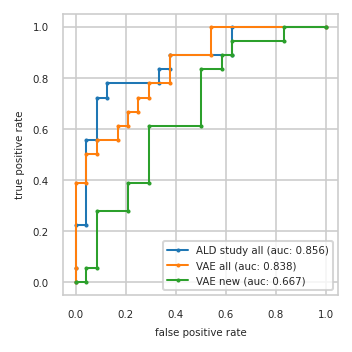

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.222   0.000 0.389   0.042 0.056
3          0.042 0.222   0.042 0.389   0.083 0.056
4          0.042 0.556   0.042 0.500   0.083 0.278
5          0.083 0.556   0.083 0.500   0.208 0.278
6          0.083 0.722   0.083 0.556   0.208 0.389
7          0.125 0.722   0.167 0.556   0.292 0.389
8          0.125 0.778   0.167 0.611   0.292 0.611
9          0.333 0.778   0.208 0.611   0.500 0.611
10         0.333 0.833   0.208 0.667   0.500 0.833
11         0.375 0.833   0.250 0.667   0.583 0.833
12         0.375 0.889   0.250 0.722   0.583 0.889
13         0.625 0.889   0.292 0.722   0.625 0.889
14         0.625 1.000   0.292 0.778   0.625 0.944
15         1.000 1.000   0.375 0.778   0.833 0.944
16           NaN   NaN   0.375 0.889   0.833 1.000
17           NaN   NaN   0.542 0.889   1.000 1.000
18           NaN   NaN   0.542 1.000     NaN   NaN
19           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P00740;P00740-2,Q12797;Q12797-10,Q8WYK1
2,Q9NR34,O75711,P51688
3,Q13231;Q13231-3,C9JF17;P05090,P31321
4,P04075,Q0P6D2,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P61981,P04075,Q96GD0
6,C9JF17;P05090,Q9Y2T3;Q9Y2T3-3,J3KSJ8;Q9UD71;Q9UD71-2
7,P14174,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,P18428,P14174,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


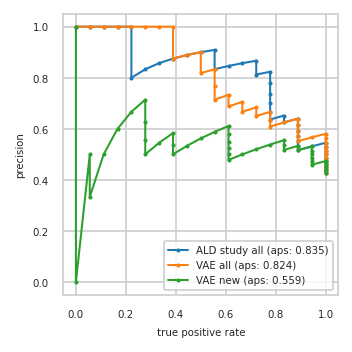

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.516 0.889     0.581 1.000     0.516 0.889
12         0.533 0.889     0.567 0.944     0.533 0.889
13         0.552 0.889     0.552 0.889     0.517 0.833
14         0.571 0.889     0.571 0.889     0.536 0.833
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.625 0.833     0.625 0.833     0.500 0.667
19         0.652 0.833     0.609 0.778     0.478 0.611
20         0.636 0.778     0.636 0.778     0.500 0.611
21         0.667 0.778     0.667 0.778     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.667 0.667     0.611 0.611
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.812 0.722     0.688 0.611     0.562 0.500
27         0.867 0.722     0.733 0.611     0.533 0.444
28         0.857 0.667     0.714 0.556     0.500 0.389
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.900 0.500     0.500 0.278
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     0.875 0.389     0.625 0.278
35         0.857 0.333     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


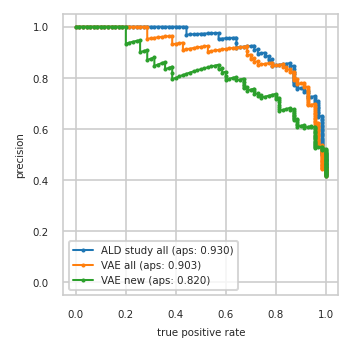

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


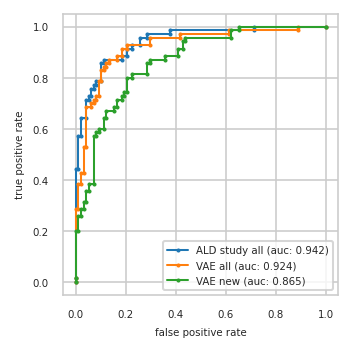

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}